In [5]:
import pandas as pd
import re, math
import matplotlib.pyplot as plt
import seaborn as sns

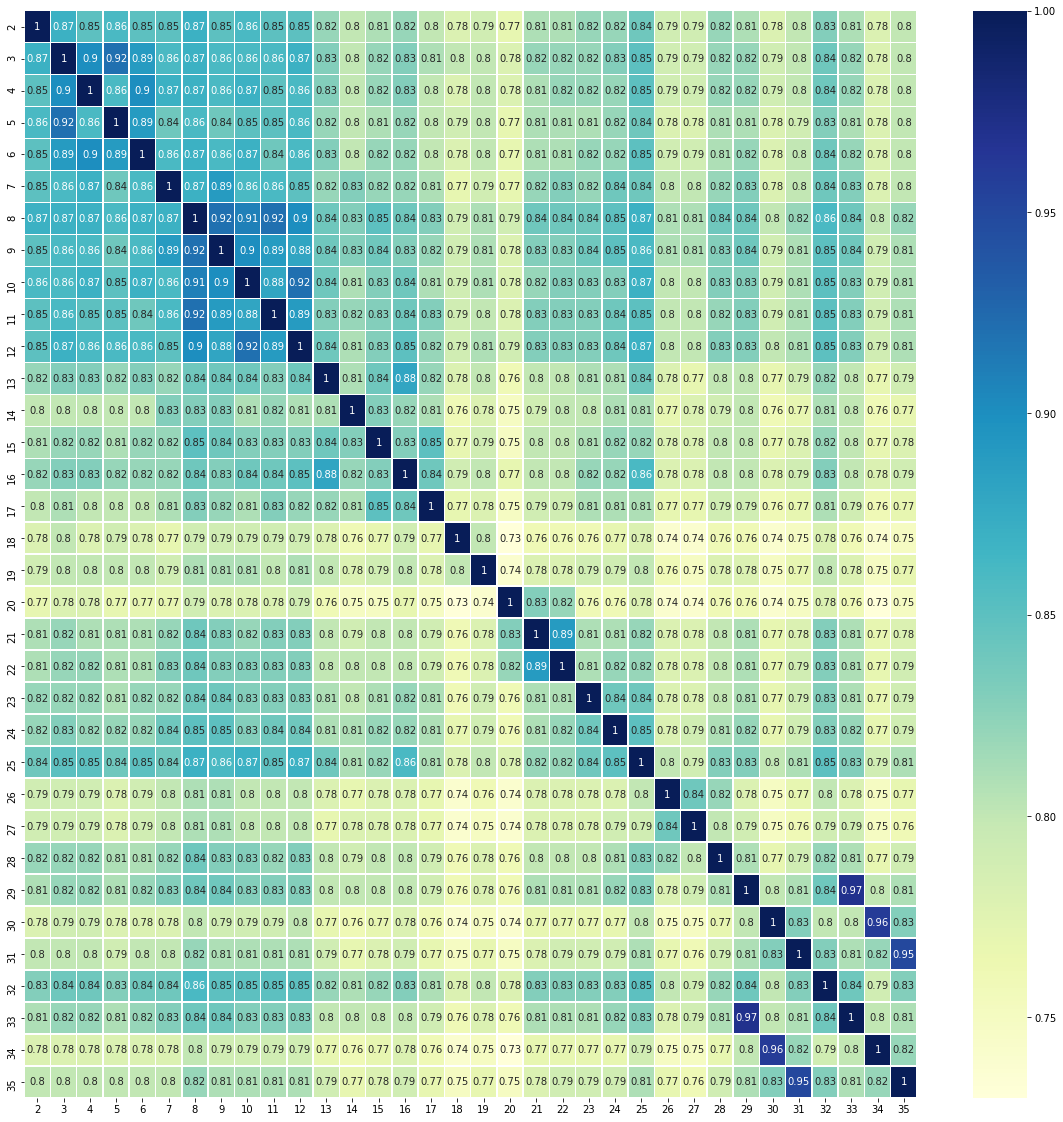

In [19]:
def load():
    return pd.read_excel('DATA.xlsx', index_col = None)

def tf_idf():
    def termF(doc, idx, c):
        length, prob = len(doc), {}
        for w in doc: # w stands for word
            if w not in c: 
                c[w] = set()
            c[w].add(idx)
            prob[w] = prob[w] + 1 / length if w in prob else 1 / length
        return prob
    
    def idF(c, numDoc):
        inv = {}
        for key, value in c.items():
            inv[key] = math.log(numDoc / len(value), 2)
        return inv
                    
    def process(document):
        return re.split('\W+', document.lower())
    
    # Start of main code
    df = load()['Text']
    numDoc = len(df)
    
    # Step 1: Calculating TF
    # c: dictionary with key = word; value = set of documents this word appears in
    c, docArr = {}, []
    for idx, document in enumerate(df):
        if not document != document:
            doc = process(document)
            f = termF(doc, idx, c)
            docArr.append(f)
            
    # Step 2: Calculating IDF
    idFVal = idF(c, numDoc)
    
    #Calculating Score
    for document in docArr: 
        for word, prob in document.items():
            newval = prob * idFVal.get(word, 0)
            document[word] = newval
    return docArr

def similarity(populated, ver):
    def euclidsim(pop, i, j):
        doc1, doc2 = pop[i], pop[j]
        ttl = 0
        for word, prob in doc1.items():
            ttl += (prob - doc2.get(word, 0)) ** 2.0 
        for word, prob in doc2.items():
            if word not in doc1:
                ttl += prob ** 2.0 
        return 1 - math.sqrt(ttl)
    
    def cossim(pop, i, j):
        doc1, doc2 = pop[i], pop[j]
        denom1, denom2, num = 0, 0, 0
        for word, prob in doc1.items():
            denom1 += prob ** 2.0
        for word, prob in doc2.items():
            denom2 += prob ** 2.0
            num += prob * doc1.get(word, 0)
        return num / (math.sqrt(denom1 * denom2))
    
    def jaccardsim(pop, i, j):
        doc1, doc2 = pop[i], pop[j]
        num, denom = 0, 0 
        for word, prob in doc1.items():
            if word in doc2: 
                num += min(prob, doc2[word])
                denom += max(prob, doc2[word])
            else:
                num += min(prob, 0)
                denom += max(prob, 0)
        for word, prob in doc2.items():
            if word not in doc1:
                num += min(prob, 0)
                denom += max(prob, 0)
        return num / denom
                
    def validDoc(df):
        c = 0
        for document in df:
            c = c + 1 if not document != document else c
        return c
    
    # Start of main code
    df = load()['Text']
    numDoc = validDoc(df)
    l = [idx + 2 for idx in range(numDoc)] #idx starts from 2 to follow excel idx
    result = [[0 for j in range(numDoc)] for i in range(numDoc)]
    for i in range(numDoc): 
        for j in range(i, numDoc): 
            val = None
            if ver == "c": 
                val = cossim(populated, i, j)
            elif ver == "j":
                val = jaccardsim(populated, i, j)
            elif ver == "e": 
                val = euclidsim(populated, i, j)
            else:
                print("No such distance exists")
                return -1
            result[i][j], result[j][i] = round(val, 2), round(val, 2)
    table = pd.DataFrame(result, l, l)
    return table

def main():
    populated = tf_idf()
    ver = "e" # c = cosine, e = euclid, j = jaccard
    t = similarity(populated, ver)
    fig, ax = plt.subplots(figsize = (20, 20))
    ax = sns.heatmap(t, annot = True, linewidths = 0.5, cmap = 'YlGnBu')
    fig.savefig(ver + "_heatmap")
    
main()